In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 87.7 MB/s eta 0:00:00


**Input Library**

In [3]:
pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
affine                                2.4.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-

In [4]:
import folium
import rasterio
import numpy as np
from matplotlib import colors
from PIL import Image

**Input Data**

In [5]:
kmeans_tif = '/content/drive/MyDrive/Pelatihan Machine Learning/Pelatihan 2/Day 4/Data/Prediksi K-means/hasil_kmeans.tif'

In [6]:
with rasterio.open(kmeans_tif) as src:
    kmeans_array = src.read(1)
    bounds = src.bounds
    nodata_val = src.nodata if src.nodata is not None else 0

**Mendapatkan nilai Unik**

In [7]:
unique_classes = np.unique(kmeans_array[kmeans_array != nodata_val])

In [8]:
unique_classes

array([0, 1, 2, 3], dtype=int32)

**Menentukan warna**

In [9]:
color_list = ['yellow','black','brown','green']
class_color_map = dict(zip(unique_classes, color_list))

In [10]:
class_color_map

{np.int32(0): 'yellow',
 np.int32(1): 'black',
 np.int32(2): 'brown',
 np.int32(3): 'green'}

In [11]:
cmap = colors.ListedColormap(color_list)

In [12]:
cmap

In [13]:
boundaries = list(range(len(unique_classes) + 1))

In [14]:
boundaries

[0, 1, 2, 3, 4]

In [15]:
norm = colors.BoundaryNorm(boundaries, ncolors=len(color_list))

In [16]:
norm

**Menentuka batas geografis**

In [17]:
bounds_latlon = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

In [18]:
bounds_latlon

[[-6.229367337726822, 106.7915413130719],
 [-6.135313727479509, 106.88155250454068]]

**Pembuatan Peta**

**Inisiasi Peta**

In [19]:
m = folium.Map(
    location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2],  # Menentukan pusat peta berdasarkan rata-rata koordinat batas
    zoom_start=10, control_scale= True  # Mengatur level zoom awal peta
)

In [20]:
m

**Tampilan Peta biasa(image)**

**Mengubah ke RGBA**

In [21]:
rgba_img = cmap(norm(kmeans_array))  # Mengonversi array K-Means ke format RGBA menggunakan colormap dan normalisasi
mask = (kmeans_array != nodata_val)  # Membuat mask boolean: True untuk data valid, False untuk nodata
rgba_img[..., 3] = mask.astype(float) * 0.8

**menyimpan ke PNG**

In [22]:

# 5. Simpan ke PNG
rgba_img_255 = (rgba_img * 255).astype(np.uint8)  # Mengonversi nilai RGBA (0-1) ke rentang 0-255 untuk format gambar
image_pil = Image.fromarray(rgba_img_255, mode='RGBA')  # Membuat objek gambar PIL dari array RGBA
image_pil.save('hasil_kmeans.png')  # Menyimpan gambar sebagai file PNG

In [24]:
folium.raster_layers.ImageOverlay(
    name= 'Hasil K-Means',
    image='/content/hasil_kmeans.png',
    bounds=bounds_latlon,
    opacity=0.7,
    interactive=True,
    cross_origin=False,
).add_to(m)



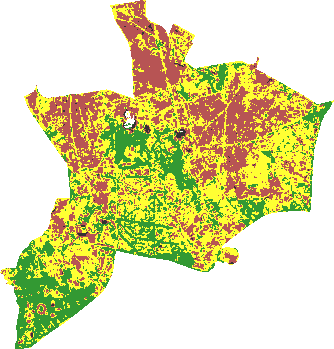

In [25]:
m

**Menambahkan untuk Layer Geospasial**

**Import Polygon**

**Input Library**

In [27]:
from rasterio.features import shapes
import geopandas as gpd
import json


**Konversi raster ke GeoJSON polygon**

In [30]:
mask = kmeans_array != nodata_val
results = (
    {"properties": {"value": int(v)}, "geometry": s}
    for s, v in shapes(kmeans_array, mask=mask, transform=src.transform)
)

geoms = list(results)


In [ ]:
geoms

In [32]:
gdf = gpd.GeoDataFrame.from_features(geoms)

In [35]:
gdf

geometry  value
0     POLYGON ((106.83008 -6.13531, 106.83008 -6.135...      0
1     POLYGON ((106.83062 -6.13558, 106.83062 -6.135...      2
2     POLYGON ((106.82631 -6.13585, 106.82631 -6.136...      0
3     POLYGON ((106.82711 -6.13585, 106.82711 -6.136...      0
4     POLYGON ((106.82819 -6.13585, 106.82819 -6.136...      0
...                                                 ...    ...
2793  POLYGON ((106.79855 -6.22829, 106.79855 -6.228...      0
2794  POLYGON ((106.79666 -6.22856, 106.79666 -6.228...      0
2795  POLYGON ((106.7972 -6.22883, 106.7972 -6.2291,...      0
2796  POLYGON ((106.79936 -6.22883, 106.79936 -6.229...      0
2797  POLYGON ((106.80017 -6.19999, 106.80017 -6.200...      3

[2798 rows x 2 columns]

In [36]:
gdf.crs = src.crs

In [38]:
gdf.to_file('Hasil_kmeans.geojson', driver="GeoJSON")

**Menambahkan Layer geojson ke Folium**

In [39]:
# Baca file GeoJSON hasil konversi
with open("Hasil_kmeans.geojson") as f:
    geojson_data = json.load(f)

# Tambahkan layer interaktif GeoJSON
folium.GeoJson(
    geojson_data,
    name="K-Means",
    style_function=lambda feature: {
        "fillColor": class_color_map.get(feature["properties"]["value"], "gray"),
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.5,
    },
    highlight_function=lambda feature: {
        "weight": 2,
        "color": "blue",
        "fillOpacity": 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=["value"], aliases=["Cluster:"]),
    popup=folium.GeoJsonPopup(fields=["value"])
).add_to(m)


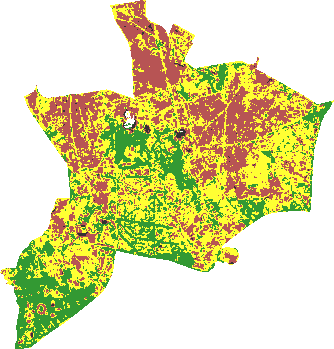

In [40]:
m

**Membuat Basemap**

In [41]:
folium.TileLayer('Cartodb Positron', attr='Map Tiles by Cartodb').add_to(m)
folium.TileLayer('Cartodb dark_matter', attr='Map Tiles by Cartodb').add_to(m)
folium.TileLayer('OpenStreetMap', attr='Map Tiles by Cartodb').add_to(m)

In [42]:
# 10. Tambahkan kontrol layer
folium.LayerControl().add_to(m)  # Menambahkan kontrol layer untuk memilih/menampilkan layer peta



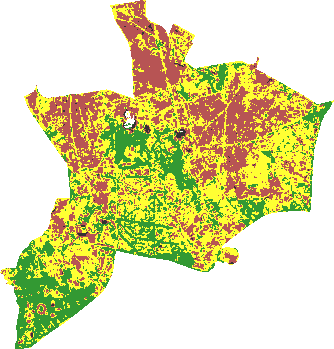

In [43]:
m


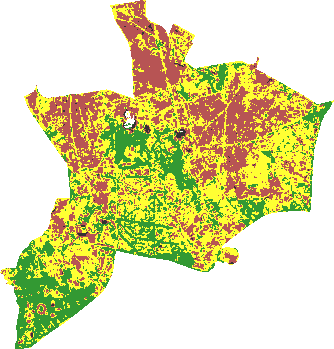

In [44]:
from branca.element import Template, MacroElement

legend_html = """
{% macro html(this, kwargs) %}
<!-- North Arrow (kompas) -->
<div style="
    position: fixed;
    bottom: 10px;
    right: 10px;
    z-index: 9999;
">
    <img src="https://png.pngtree.com/png-clipart/20220905/ourmid/pngtree-arah-mata-angin-png-image_6138728.png" style="width:50px; height:50px;" />
</div>

<!-- Legend Box -->
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index:9999;
    background-color: white;
    padding: 10px;
    border: 2px solid grey;
    border-radius: 5px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    font-size:14px;
">
    <strong>Legenda KMeans</strong><br>
    <i style="background:yellow; width:15px; height:15px; float:left; margin-right:8px;"></i>Kelas 1<br>
    <i style="background:black; width:15px; height:15px; float:left; margin-right:8px;"></i>Kelas 2<br>
    <i style="background:brown; width:15px; height:15px; float:left; margin-right:8px;"></i>Kelas 3<br>
    <i style="background:green; width:15px; height:15px; float:left; margin-right:8px;"></i>Kelas 4<br>
</div>

{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)


In [45]:
m.save('/content/drive/MyDrive/Pelatihan Machine Learning/Pelatihan 2/Day 4/Result/Hasil_Kmeans.html')